# CIBMTR | EfficientNetV2

This notebook employs the EfficientNetV2 backbone.

I created this notebook based on [ISIC2024: KerasCV Starter](http://www.kaggle.com/code/awsaf49/isic2024-kerascv-starter).

The data processing referred to [[Public] Classifier+CAT+XGB LB 0.688](http://www.kaggle.com/code/kendontcare11/public-classifier-cat-xgb-lb-0-688).

Comments and Suggestions are always welcome.



# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import StratifiedGroupKFold
import keras
import tensorflow as tf
import keras_cv
from keras import ops
import cv2
from glob import glob
from tqdm.notebook import tqdm
import joblib
import matplotlib.pyplot as plt

# Library Versions

In [2]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasCV:", keras_cv.__version__)

TensorFlow: 2.17.1
Keras: 3.5.0
KerasCV: 0.9.0


# Configuration

In [3]:
class Config:
    verbose = 1
    seed = 42
    batch_size = 128
    epochs = 30
    lr_mode = "cos"
    preset = "efficientnetv2_b2"
    class_names = ['efs']
    num_classes = 1

In [4]:
#Sets value for random seed to produce similar result in each run
keras.utils.set_random_seed(Config.seed)

# Dataset Path

In [5]:
PATH = '/kaggle/input/equity-post-HCT-survival-predictions'

In [6]:
#train + valid
df = pd.read_csv(f'{PATH}/train.csv')
df = df.ffill()
display(df.head(3))

#test
test_df = pd.read_csv(f'{PATH}/test.csv')
test_df = test_df.ffill()
display(test_df.head(3))

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10
0,28800,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0
1,28801,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0
2,28802,N/A - non-malignant indication,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0


# Class Distribution
There is a class balance in the dataset.

In [7]:
print("Class Distribution (%):")
display(df.efs.value_counts(normalize=True)*100)

Class Distribution (%):


efs
1.0    53.930556
0.0    46.069444
Name: proportion, dtype: float64

# Class Weight

In [8]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(df['efs']), y=df['efs'])
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 1.0853180584865842, 1: 0.9271182075714653}


# Data Split


In [9]:
df = df.reset_index(drop=True)
df["fold"]=-1

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=Config.seed)
for i, (train_idx, valid_idx) in enumerate(sgkf.split(df, y=df.efs, groups=df.ID)):
    df.loc[valid_idx, "fold"] = int(i)

#use first fold for training and validation
train_df = df.query("fold!=0")
valid_df = df.query("fold==0")
print(f"# Num Train: {len(train_df)} | Num Validation: {len(valid_df)}")

# Num Train: 23040 | Num Validation: 5760


Class Distribution in Training

In [10]:
train_df.efs.value_counts()

efs
1.0    12442
0.0    10598
Name: count, dtype: int64

Class Distribution in Validation

In [11]:
valid_df.efs.value_counts()

efs
1.0    3090
0.0    2670
Name: count, dtype: int64

# Features
It is encouraged to try other data processing methods.

In [12]:
hct_ci_mapping = {
    "arrhythmia": {"No": 0, "Not done": 0, "Yes": 1},
    "cardiac": {"No": 0, "Not done": 0, "Yes": 1},
    "diabetes": {"No": 0, "Not done": 0, "Yes": 1},
    "hepatic_mild":{"No": 0, "Not done": 0, "Yes": 1},
    "hepatic_severe": {"No": 0, "Not done": 0, "Yes": 3},
    "psych_disturb": {"No": 0, "Not done": 0, "Yes": 1},
    "obesity": {"No": 0, "Not done": 0, "Yes": 1},
    "rheum_issue": {"No": 0, "Not done": 0, "Yes": 2},
    "peptic_ucler": {"No": 0, "Not done": 0, "Yes": 2},
    "renal_issue": {"No": 0, "Not done": 0, "Yes": 2},
    "prior_tumor": {"No": 0, "Not done": 0, "Yes": 3},
    "pulm_moderate": {"No": 0, "Not done": 0, "Yes": 2},
    "pulm_severe": {"No": 0, "Not done": 0, "Yes": 3},
}

In [13]:
def calculate_hct_ci_score(row, mapping):
    score = 0
    if "hepatic_severe" in row and row["hepatic_severe"] == "Yes":
        score += mapping["hepatic_severe"]["Yes"]
    elif "hepatic_mild" in row and row["hepatic_mild"] =="Yes":
        score += mapping["hepatic_mild"]["Yes"]
    if "pulm_moderate" in row and row["pulm_moderate"] == "Yes":
        score += mapping["pulm_moderate"]["Yes"]
    elif "pulm_severe" in row and row["pulm_severe"] == "Yes":
        score += mapping["pulm_severe"]["Yes"]
    for condition, mapping_values in mapping.items():
        if condition not in ["hepatic_mild", "hepatic_severe", "pulm_moderate", "pulm_severe"] and condition in row:
            score += mapping_values.get(row[condition], 0)
    return score

In [14]:
def num(df):
    df['conditioning_intensity'] = df['conditioning_intensity'].map({
        'NMA': 1,
        'RIC': 2,
        'MAC': 3,
        'TBD': None,
        'No drugs reported': None,
        'N/A, F(pre-TED) not submitted': None
    })
    df['tbi_status'] = df['tbi_status'].map({
        'No TBI': 0,
        'TBI +- Other, <=cGy': 1,
        'TBI +- Other, -cGy, fractionated': 2,
        'TBI + Cy +- Other': 3,
        'TBI +- Other, -cGy, single': 4,
        'TBI +- Other, >cGy': 5,
        'TBI +- Other, unknown does': None
    })
    df['dri_score'] = df['dri_score'].map({
        'Low': 1,
        'Intermediate': 2,
        'Intermediate - TED AML case <missing cytogenetics': 3,
        'High': 4,
        'High - TED AML case <missing sytogenetics': 5,
        'Very High': 6,
        'N/A - pediatric': -3,
        'N/A - non-malignant indication': -1,
        'TBD cytogenetics': -2,
        'N/A - disease not classifiable': -4,
        'Missing disease status': 0
    })
    df['cyto_score'] = df['cyto_score'].map({
        'Poor': 4,
        'Normal': 3,
        'Intermediate': 2,
        'Favorable': 1,
        'TBD': -1,
        'Other': -2,
        'Not tested': None
    })
    df['cyto_score_detail'] = df['cyto_score_detail'].map({
        'Poor': 3,
        'Intermedia': 2,
        'Favorable': 1,
        'TBD': -1,
        'Not tested': None
    })
    return df

In [15]:
def fill_hla_combined_low(row):
    if np.isnan(row['hla_combined_low']):
        components = [
            row['hla_match_drb1_row'], row['hla_match_dqb1_low'],
            row['hla_match_a_low'], row['hla_match_b_low'], row['hla_match_c_low']
        ]
        if all([not np.isnan(x) for x in components]):
            return sum(components)
        else:
            if not np.isnan(row['hla_low_res_8']) and not np.isnsn(row['hla_match_dqb1_low']):
                return row['hla_low_res_8'] + row['hla_match_dqb1_low']
            elif not np.isnan(row['hla_low_res_6']):
                components_6 = [
                    row['hla_match_dqb1_low'], row['hla_match_c_low']
                ]
                if all([not np.isnan(x) for x in components_6]):
                    return row['hla_low_res_6'] + sum(components_6)
                else:
                    return sum([x for x in components if not np.isnan(x)])
    return row['hla_combined_low']

In [16]:
RMV = ["ID", "efs", "efs_time", "y", "race_group","fold","hla_match_c_high","cyto_score","tce_div_match","tce_imm_match","hla_high_res_10","hla_high_res_8"]
FEATURES = [c for c in train_df.columns if not c in RMV]

In [17]:
CATS = []
combined = pd.concat([train_df,valid_df,test_df],axis=0, ignore_index=True)
print("label encode the catgorical features:", end="")

for c in FEATURES:
    if train_df[c].dtype=='object':
        CATS.append(c)
        train_df[c] = train_df[c].fillna("NAN")
        valid_df[c] = valid_df[c].fillna("NAN")
        test_df[c] = test_df[c].fillna("NAN")
print("label encode the categorical features:", end="")       
for c in FEATURES:
    if c in CATS:
        print(f"{c},", end="")
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        combined[c] = combined[c].astype("int32")
        combined[c] = combined[c].astype("category")
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")

train_df = combined.iloc[:len(train_df)].copy()
valid_df = combined.iloc[:len(train_df):].reset_index(drop=True).copy()
test_df = combined.iloc[len(train_df):].reset_index(drop=True).copy()
              

label encode the catgorical features:label encode the categorical features:dri_score,psych_disturb,diabetes,tbi_status,arrhythmia,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,cmv_status,rituximab,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,obesity,mrd_hct,in_vivo_tcd,tce_match,hepatic_severe,prior_tumor,peptic_ulcer,gvhd_proph,rheum_issue,sex_match,hepatic_mild,donor_related,melphalan_dose,cardiac,pulm_moderate,

categorical_columns = ["dri_score", "psych_disturb", "cyto_score", "diabetes", "tbi_status",
                      "arrhythmia", "graft_type", "vent_hist", "renal_issue", "pulm_severe", 
                      "prim_disease_hct", "cmv_status", "tce_imm_match", "rituximab",
                       "prod_type", "cyto_score_detail", "conditioning_intensity", 
                       "ethnicity",
                     "obesity", "mrd_hct",
                       "in_vivo_tcd", "tce_match", "hepatic_severe",
                      "prior_tumor", "peptic_ulcer", "gvhd_proph", "rheum_issue", "sex_match",
                      "race_group",
                       "hepatic_mild", 
                       "tce_div_match",
                       "donor_related", "melphalan_dose",
                      "cardiac", "pulm_moderate"
]
numeric_columns = ["hla_match_c_high", "hla_high_res_8", "hla_low_res_6", "hla_high_res_6",
                  "hla_high_res_10", "hla_match_dqb1_high", "hla_nmdp_6", "hla_match_c_low",
                  "hla_match_drb1_low", "hla_match_dqb1_low", "year_hct", "hla_match_a_high", 
                   "donor_age", "hla_match_b_low", "age_at_hct", "hla_match_a_low","hla_match_b_high",
                  "comorbidity_score", "karnofsky_score", "hla_low_res_8", "hla_match_drb1_high", 
                  "hla_low_res_10", ]
feature_columns = categorical_columns + numeric_columns

In [18]:
def build_dataset(
    ID,
    FEATURES,
    labels=None,
    batch_size=32,
    shuffle=1024,
    cache=True,
    drop_remainder=False
):
    AUTO = tf.data.experimental.AUTOTUNE
    inp = {"FEATURES":FEATURES}
    slices = (inp, labels) if labels is not None else inp
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.cache() if cache else ds
    #ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    if shuffle:
        ds = ds.shuffle(shuffle, seed = Config.seed)
        opt = tf.data.Options()
        opt.deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.prefetch(AUTO)
    return ds

# Build Training and Validation Dataset

In [19]:
#train
train_FEATURES = dict(train_df[FEATURES])
train_ID = train_df.ID.values
train_labels = train_df.efs.values
train_ds = build_dataset(train_ID, train_FEATURES, train_labels, batch_size = Config.batch_size,
                        shuffle = True)

In [20]:
#valid
valid_FEATURES = dict(valid_df[FEATURES])
valid_ID = valid_df.ID.values
valid_labels = valid_df.efs.values
valid_ds = build_dataset(valid_ID, valid_FEATURES, valid_labels, batch_size = Config.batch_size,
                        shuffle = False)

In [21]:
feature_space = keras.utils.FeatureSpace(
    features = {
        "dri_score":"float_normalized",
        "psych_disturb":"float_normalized",
        #"cyto_score":"float_normalized",
        "diabetes":"float_normalized",
        "tbi_status":"float_normalized",
        "arrhythmia":"float_normalized",
        "graft_type":"float_normalized",
        "vent_hist":"float_normalized",
        "renal_issue":"float_normalized",
        "pulm_severe":"float_normalized",
        "prim_disease_hct":"float_normalized",
        "cmv_status":"float_normalized", 
        #"tce_imm_match":"float_normalized",
        "rituximab":"float_normalized",
        "prod_type":'float_normalized',
        "cyto_score_detail":"float_normalized",
        "conditioning_intensity":"float_normalized",
        "ethnicity":"float_normalized",
        "obesity":"float_normalized",
        "mrd_hct":"float_normalized",
        "in_vivo_tcd":"float_normalized",
        "tce_match":"float_normalized",
        "hepatic_severe":"float_normalized",
        "prior_tumor":"float_normalized",
        "peptic_ulcer":"float_normalized",
        "gvhd_proph":"float_normalized",
        "rheum_issue":"float_normalized",
        "sex_match":"float_normalized",
        #"race_group":"float_normalized",
        "hepatic_mild":"float_normalized",
        #"tce_div_match":"float_normalized",
        "donor_related":"float_normalized",
        "melphalan_dose":"float_normalized",
        "cardiac":"float_normalized",
        "pulm_moderate":"float_normalized",  
        "year_hct":"float_discretized", 
        "age_at_hct":"float_discretized",
        "donor_age":"float_discretized",
        #"hla_match_c_high":"float_normalized",
        #"hla_high_res_8":"float_normalized",
        "hla_low_res_6":"float_normalized",
        "hla_high_res_6":"float_normalized",
        #"hla_high_res_10":"float_normalized",
        "hla_match_dqb1_high":"float_normalized",
        "hla_nmdp_6":"float_normalized",
        "hla_match_c_low":"float_normalized",
        "hla_match_drb1_low":"float_normalized",
        "hla_match_dqb1_low":"float_normalized",
        "hla_match_a_high":"float_normalized", 
        "hla_match_b_low":"float_normalized", 
        "hla_match_a_low":"float_normalized",
        "hla_match_b_high":"float_normalized",
        "comorbidity_score":"float_normalized",
        "karnofsky_score":"float_normalized",
        "hla_low_res_8":"float_normalized", 
        "hla_match_drb1_high":"float_normalized", 
        "hla_low_res_10":"float_normalized", 
        #"hct_ci_score":"float_normalized",
        #"donor_recipient_age_diff":"float_normalized",
        #"hla_combined_low":"float_normalized",
        #"hla_match_ratio":"float_normalized",
        #"years_since_2000":"float_normalized",
        #"null_count":"float_normalized",
        #"ci_score_danger":"float_normalized",
        #"fold":"float_normalized",
    },
    output_mode='concat',
)

In [22]:
train_ds_with_no_labels = train_ds.map(lambda x, _: x["FEATURES"])
feature_space.adapt(train_ds_with_no_labels)

In [23]:
for x, _ in train_ds.take(1):
    preprocessed_x = feature_space(x["FEATURES"])
    print("preprocessed_x.shape:", preprocessed_x.shape)
    print("preprocessed_x.dtype:", preprocessed_x.dtype)

preprocessed_x.shape: (128, 143)
preprocessed_x.dtype: <dtype: 'float32'>


Feature Processing

In [24]:
train_ds = train_ds.map(
    lambda x, y: ({"FEATURES": feature_space(x["FEATURES"])}, y), num_parallel_calls=tf.data.AUTOTUNE)

In [25]:
valid_ds = valid_ds.map(
    lambda x, y: ({"FEATURES": feature_space(x["FEATURES"])}, y), num_parallel_calls=tf.data.AUTOTUNE)

# Loss and Metrics

In [26]:
auc = keras.metrics.AUC()
loss = keras.losses.BinaryCrossentropy(label_smoothing=0.02)

# Modeling

In [27]:
#define input layers
feat_input = keras.Input(shape=(feature_space.get_encoded_features().shape[1],), name="FEATURES")
inp = {"FEATURES":feat_input}

#feature input
backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(Config.preset)
x1 = keras.layers.Dense(3072, activation="selu")(feat_input)
x1 = keras.layers.Dense(2560, activation="selu")(x1)
x1 = keras.layers.Dense(2048, activation="selu")(x1)
x1 = keras.layers.Dense(1536, activation="selu")(x1)
x1 = keras.layers.Dense(1024,activation="selu")(x1)
x1 = keras.layers.Dense(720,activation="selu")(x1)
x1 = keras.layers.Dense(640,activation="selu")(x1)
#x1 = keras.layers.Dropout(0.1)(x1)

#output layer
out = keras.layers.Dense(1, activation='sigmoid', dtype="float32")(x1)

#build model
model = keras.models.Model(feat_input, out)

In [28]:
#compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss = loss,
    metrics = [auc],)

#model.summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ FEATURES (InputLayer)                │ (None, 143)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3072)                │         442,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2560)                │       7,866,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2048)                │       5,244,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1536)                │       3,147,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │       1,573,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 720)                 │         738,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 640)                 │         461,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             641 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,475,409 (74.29 MB)

 Trainable params: 19,475,409 (74.29 MB)

 Non-trainable params: 0 (0.00 B)

# Plot Model

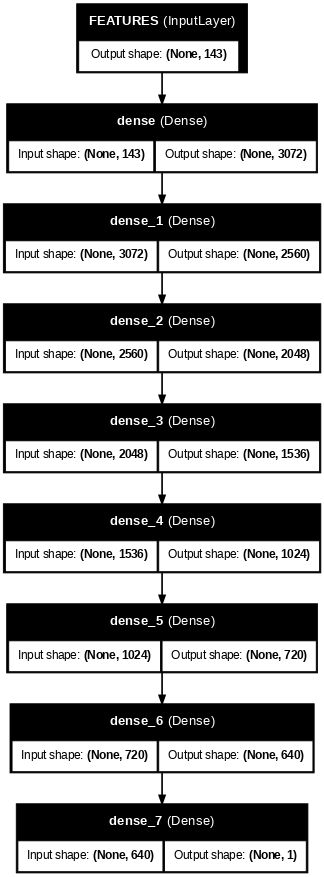

In [29]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, dpi=60)

# Learning Rate

In [30]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 6e-5, 5e-4, 4e-6
    lr_ramp_ep, lr_sus_ep, lr_decay = 0, 0, 0.8

    def lrfn(epoch):
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep +lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay ** (epoch - lr_ramp_ep -lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos': 
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr-sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
       
        return lr
        
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch');plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()
        
    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)

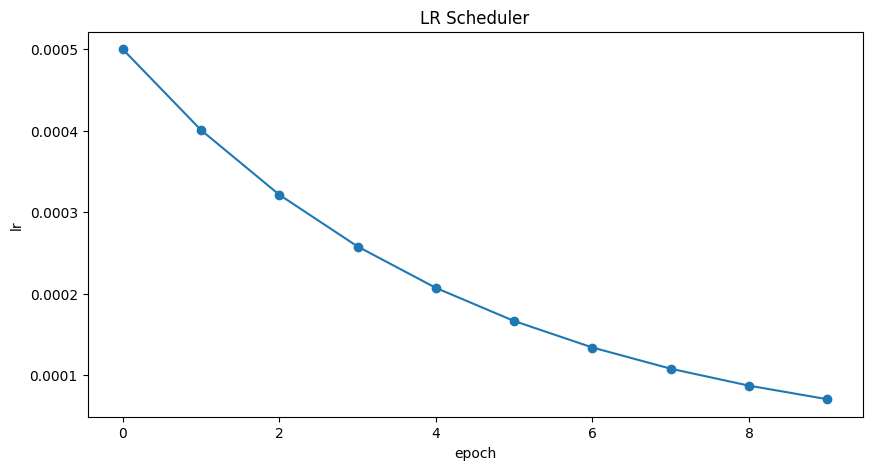

In [31]:
lr_cb = get_lr_callback(Config.batch_size, mode="exp", plot=True)

# Model Checkpoint

In [32]:
ckpt_cb = keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    monitor="val_auc",
    save_best_only=True,
    save_weights_only=False,
    mode="max"
)

# Training

In [33]:
history = model.fit(
    train_ds,
    epochs=Config.epochs,
    callbacks=[lr_cb, ckpt_cb],
    validation_data=valid_ds,
    verbose=Config.verbose,
    class_weight=class_weights,
)

Epoch 1/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - auc: 0.5804 - loss: 1.4036 - val_auc: 0.6630 - val_loss: 0.6997 - learning_rate: 5.0000e-04
Epoch 2/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - auc: 0.6402 - loss: 0.6985 - val_auc: 0.6887 - val_loss: 0.6482 - learning_rate: 4.0080e-04
Epoch 3/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - auc: 0.6647 - loss: 0.6708 - val_auc: 0.7164 - val_loss: 0.6249 - learning_rate: 3.2144e-04
Epoch 4/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - auc: 0.6946 - loss: 0.6421 - val_auc: 0.7361 - val_loss: 0.6122 - learning_rate: 2.5795e-04
Epoch 5/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - auc: 0.7123 - loss: 0.6280 - val_auc: 0.7493 - val_loss: 0.5965 - learning_rate: 2.0716e-04
Epoch 6/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - auc: 0.7416 - loss: 0.6038 - val_auc: 0.7690 - val_loss: 0.5812 - learning_rate: 1.6653e-04
Epoch 7/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - auc: 0.7686 - loss: 0.5801 - val_auc: 0.7910 - val_loss: 0.5700

# Visualize AUC with Epochs

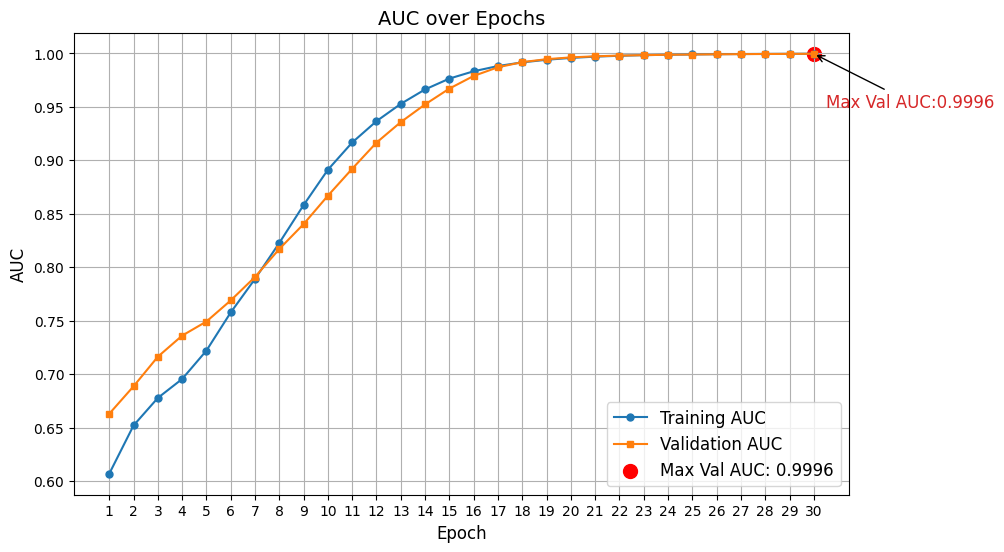

In [34]:
auc = history.history['auc']
val_auc = history.history['val_auc']
epochs = range(1, len(auc) + 1)
max_val_auc_epoch = np.argmax(val_auc)
max_val_auc = val_auc[max_val_auc_epoch]

plt.figure(figsize=(10,6))
plt.plot(epochs, auc, 'o-', label="Training AUC", markersize=5, color='tab:blue')
plt.plot(epochs, val_auc, 's-', label='Validation AUC', markersize=5, color='tab:orange')

plt.scatter(max_val_auc_epoch + 1, max_val_auc, color='red', s=100, label=f'Max Val AUC: {max_val_auc:.4f}')
plt.annotate(f'Max Val AUC:{max_val_auc:.4f}',
             xy=(max_val_auc_epoch + 1, max_val_auc), 
             xytext=(max_val_auc_epoch + 1 + 0.5, max_val_auc - 0.05),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=12,color='tab:red')
plt.title('AUC over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.xticks(epochs)
plt.show()

# Result

In [35]:
best_score = max(history.history['val_auc'])
best_epoch = np.argmax(history.history['val_auc']) + 1
print(f"Best AUC: {best_score:.5f}")
print(f"Best Epoch: {best_epoch}")

Best AUC: 0.99965
Best Epoch: 30


# Prediction

Load Best Model

In [36]:
model.load_weights("best_model.keras")

Build Testing Dataset

In [37]:
test_FEATURES = dict(test_df[FEATURES])
test_ID = test_df.ID.values
test_ds = build_dataset(test_ID, test_FEATURES, batch_size=Config.batch_size,shuffle=False)
test_ds = test_ds.map(
    lambda x: {"FEATURES":feature_space(x["FEATURES"])}, num_parallel_calls=tf.data.AUTOTUNE)

Inference

In [38]:
preds = model.predict(test_ds).squeeze()

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


# Submission

In [39]:
pred_df = test_df[["ID"]].copy()
pred_df["prediction"] = preds.tolist()

In [40]:
sub_df = pd.read_csv(f'{PATH}/sample_submission.csv')
sub_df = sub_df[["ID"]].copy()

sub_df = sub_df.merge(pred_df, on ="ID", how="left")
sub_df.to_csv("submission.csv", index=False)
sub_df.head()

,ID,prediction
0,28800,0.623429
1,28801,0.922120
2,28802,0.027231
